# READ DATA

In [2]:
import pandas as pd
df = pd.read_csv("C:/Users/Lenovo/OneDrive - db/Dattabot 1/AI LLM/Anomali Detection/kmp_legundi_dataset.csv")
df = df[["Timestamp", "temperature_exh1","pressure_lo1"]]
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df

Timestamp  temperature_exh1  pressure_lo1
0   2024-12-13 14:00:00               378           4.0
1   2024-12-13 15:00:00               150           4.3
2   2024-12-13 16:00:00               454           4.4
3   2024-12-13 17:00:00               170           4.3
4   2024-12-13 18:00:00               143           4.3
..                  ...               ...           ...
598 2025-01-07 12:00:00               172           4.3
599 2025-01-07 13:00:00               452           4.4
600 2025-01-07 14:00:00               290           4.3
601 2025-01-07 15:00:00               211           4.4
602 2025-01-07 16:00:00               460           4.4

[603 rows x 3 columns]

# Feature Engineering

In [3]:
data = df.copy()

data['MA_3h'] = data['temperature_exh1'].rolling(window=3).mean()
data['MA_4h'] = data['temperature_exh1'].rolling(window=4).mean()
data['Rol_STD_3h'] = data['temperature_exh1'].rolling(window=3).std()
data['Rol_STD_4h'] = data['temperature_exh1'].rolling(window=4).std()
data['ROC'] = data['temperature_exh1'].diff()
data

Timestamp  temperature_exh1  pressure_lo1       MA_3h   MA_4h  \
0   2024-12-13 14:00:00               378           4.0         NaN     NaN   
1   2024-12-13 15:00:00               150           4.3         NaN     NaN   
2   2024-12-13 16:00:00               454           4.4  327.333333     NaN   
3   2024-12-13 17:00:00               170           4.3  258.000000  288.00   
4   2024-12-13 18:00:00               143           4.3  255.666667  229.25   
..                  ...               ...           ...         ...     ...   
598 2025-01-07 12:00:00               172           4.3  259.333333  263.50   
599 2025-01-07 13:00:00               452           4.4  359.666667  307.50   
600 2025-01-07 14:00:00               290           4.3  304.666667  342.25   
601 2025-01-07 15:00:00               211           4.4  317.666667  281.25   
602 2025-01-07 16:00:00               460           4.4  320.333333  353.25   

     Rol_STD_3h  Rol_STD_4h    ROC  
0           NaN         NaN    NaN  
1           NaN         NaN -228.0  
2    158.206616         NaN  304.0  
3    170.035290  151.243733 -284.0  
4    172.291420  150.269480  -27.0  
..          ...         ...    ...  
598  169.777305  138.872844 -283.0  
599  162.531023  168.808570  280.0  
600  140.575010  137.201494 -162.0  
601  122.858998  123.966057  -79.0  
602  127.241241  122.994241  249.0  

[603 rows x 8 columns]

# Model Unsupervised - Isolation Forest

## 1. STD 3h

In [4]:
data_Rol_STD_3h = data.copy()
features_column = ['Rol_STD_3h','pressure_lo1'] # bisa disesuikan kolom featurenya
timestamp = data_Rol_STD_3h['Timestamp']
                
# data_Rol_STD_3h = data_Rol_STD_3h.dropna()

# Menentukan ambang batas 2 kali rata rata std
threshold = data_Rol_STD_3h['Rol_STD_3h'].mean() * 2

# Menentukan apakah suatu data adalah anomali
data_Rol_STD_3h['anomaly'] = (data_Rol_STD_3h['Rol_STD_3h'] > threshold).astype(int)

# Membagi data menjadi train (80%) dan test (20%) berdasarkan urutan waktu
split_index = int(len(data_Rol_STD_3h) * 0.8)
train_data_Rol_STD_3h = data_Rol_STD_3h.iloc[:split_index]
test_data_Rol_STD_3h = data_Rol_STD_3h.iloc[split_index:]

test_data_Rol_STD_3h['decision_score'] = test_data_Rol_STD_3h['Rol_STD_3h']

# Menghitung metrik evaluasi
decision_max = test_data_Rol_STD_3h['decision_score'].max()
decision_mean = test_data_Rol_STD_3h['decision_score'].mean()
decision_min = test_data_Rol_STD_3h['decision_score'].min()
decision_std = test_data_Rol_STD_3h['decision_score'].std()
proportion_anomalies = test_data_Rol_STD_3h['anomaly'].mean() * 100

# Menampilkan hasil evaluasi
print(f'Decision Scores (Max): {decision_max:.6f}')
print(f'Decision Scores (Mean): {decision_mean:.6f}')
print(f'Decision Scores (Min): {decision_min:.6f}')
print(f'Decision Scores (Std Dev): {decision_std:.6f}')
print(f'Proportion of Anomalies: {proportion_anomalies:.2f}%')


Decision Scores (Max): 171.389420
Decision Scores (Mean): 141.066026
Decision Scores (Min): 55.716545
Decision Scores (Std Dev): 24.906914
Proportion of Anomalies: 0.00%


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7256\3225679162.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_Rol_STD_3h['decision_score'] = test_data_Rol_STD_3h['Rol_STD_3h']


## 2. MA 3h

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

# Apakah ingin menggunakan hyperparameter tuning?
use_hypertuning = False  # Ganti ke False jika ingin menggunakan Isolation Forest default

# Copy dataset
data_MA_3h = data.copy()
features_column = ['MA_3h','pressure_lo1']  # Sesuaikan fitur yang digunakan
timestamp = data_MA_3h['Timestamp']


# Menghapus NaN karena rolling window menghasilkan nilai kosong di awal
data_MA_3h = data_MA_3h.dropna(subset=["MA_3h"]).reset_index(drop=True)

# Membagi data menjadi train (80%) dan test (20%) secara berurutan
split_index = int(len(data_MA_3h) * 0.8)
train_data_MA_3h = data_MA_3h.iloc[:split_index].copy()
test_data_MA_3h = data_MA_3h.iloc[split_index:].copy()

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': ['auto', 0.5, 0.8, 1.0],
        'contamination': [0.05, 0.1, 0.15]
    }

    model = IsolationForest(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(train_data_MA_3h[features_column])

    # Menggunakan model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    model = grid_search.best_estimator_

else:
    # Jika tidak menggunakan tuning, gunakan parameter default
    model = IsolationForest(contamination=0.1, n_estimators=50,random_state=42)
    model.fit(train_data_MA_3h[features_column])

# Memprediksi anomali pada data test
test_data_MA_3h['anomaly'] = model.predict(test_data_MA_3h[features_column])
test_data_MA_3h['anomaly'] = test_data_MA_3h['anomaly'].map({1: 0, -1: 1})  # Konversi (-1) ke 1 (anomali), (1) ke 0 (normal)

# Mendapatkan decision scores dari model
test_data_MA_3h['decision_score'] = model.decision_function(test_data_MA_3h[features_column])

# Menghitung statistik dari decision scores
decision_max = test_data_MA_3h['decision_score'].max()
decision_mean = test_data_MA_3h['decision_score'].mean()
decision_min = test_data_MA_3h['decision_score'].min()
decision_std = test_data_MA_3h['decision_score'].std()

# Menghitung Proportion of Anomalies (PAD)
proportion_anomalies = test_data_MA_3h['anomaly'].mean() * 100

# Menampilkan hasil evaluasi
print(f'Decision Scores (Max): {decision_max:.6f}')
print(f'Decision Scores (Mean): {decision_mean:.6f}')
print(f'Decision Scores (Min): {decision_min:.6f}')
print(f'Decision Scores (Std Dev): {decision_std:.6f}')
print(f'Proportion of Anomalies: {proportion_anomalies:.2f}%')


Decision Scores (Max): 0.153071
Decision Scores (Mean): 0.107152
Decision Scores (Min): -0.129055
Decision Scores (Std Dev): 0.053191
Proportion of Anomalies: 5.79%


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [6]:
test_data_MA_3h['anomaly'].value_counts()

anomaly
0    114
1      7
Name: count, dtype: int64

In [7]:
test_data_MA_3h.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Timestamp', 'temperature_exh1', 'pressure_lo1', 'MA_3h', 'MA_4h',
       'Rol_STD_3h', 'Rol_STD_4h', 'ROC', 'anomaly', 'decision_score'],
      dtype='object')>

In [8]:
test_data_MA_3h = test_data_MA_3h[['Timestamp', 'temperature_exh1', 'MA_3h','pressure_lo1','anomaly', 'decision_score']]
test_data_MA_3h_anomalies = test_data_MA_3h[test_data_MA_3h['anomaly']==1]
test_data_MA_3h_anomalies

Timestamp  temperature_exh1       MA_3h  pressure_lo1  anomaly  \
503 2025-01-03 15:00:00               423  301.000000           3.4        1   
515 2025-01-04 03:00:00               407  401.333333           4.4        1   
516 2025-01-04 04:00:00               455  401.666667           4.1        1   
534 2025-01-04 22:00:00               462  295.000000           3.7        1   
569 2025-01-06 09:00:00               210  293.333333           3.6        1   
575 2025-01-06 15:00:00               453  365.666667           4.5        1   
584 2025-01-07 00:00:00               330  334.000000           4.6        1   

     decision_score  
503       -0.129055  
515       -0.064532  
516       -0.094113  
534       -0.078716  
569       -0.100955  
575       -0.012507  
584       -0.018824

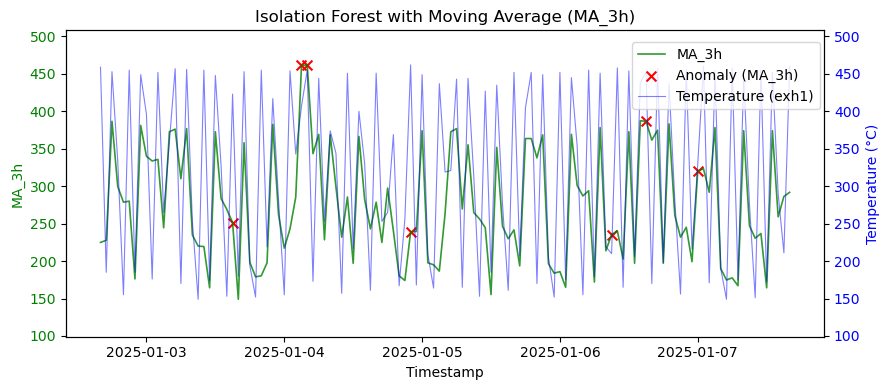

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data untuk visualisasi
timestamps = test_data_MA_3h['Timestamp']
temperature_values = test_data_MA_3h['temperature_exh1']
MA_3h_values = test_data_MA_3h['MA_3h']
anomalies = test_data_MA_3h['anomaly']  # Kolom 'anomaly' yang sudah ada

# Normalisasi MA_3h ke dalam rentang suhu
MA_3h_min, MA_3h_max = MA_3h_values.min(), MA_3h_values.max()
temp_min, temp_max = temperature_values.min(), temperature_values.max()

# Normalisasi MA_3h menggunakan Min-Max Scaling ke rentang suhu
scaled_MA_3h_values = (MA_3h_values - MA_3h_min) / (MA_3h_max - MA_3h_min) * (temp_max - temp_min) + temp_min

# Tentukan rentang yang sama untuk kedua grafik pada sumbu Y
y_min = min(temperature_values.min(), scaled_MA_3h_values.min()) - 50
y_max = max(temperature_values.max(), scaled_MA_3h_values.max()) * 1.1

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot MA_3h yang sudah diskalakan di sumbu kiri dengan garis tipis
ax1.plot(timestamps, scaled_MA_3h_values, label='MA_3h', color='green', linestyle='-', alpha=0.8, linewidth=1.2)
ax1.set_ylabel('MA_3h', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y

# Menandai titik anomali pada MA_3h (berdasarkan kolom anomaly)
ax1.scatter(timestamps[anomalies == 1], scaled_MA_3h_values[anomalies == 1], 
            color='red', label='Anomaly (MA_3h)', marker='x', s=50)

# Buat sumbu kanan untuk Temperature (exh1) dengan garis tipis
ax2 = ax1.twinx()
ax2.plot(timestamps, temperature_values, label='Temperature (exh1)', color='blue', alpha=0.5, linewidth=0.8)
ax2.set_ylabel('Temperature (°C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y agar sejajar

# Tambahkan judul dan legenda
ax1.set_xlabel('Timestamp')
ax1.set_title('Isolation Forest with Moving Average (MA_3h)')

# Letakkan legenda di tengah kiri
fig.legend(loc='upper left', bbox_to_anchor=(0.7, 0.9))

# Rotasi label timestamp agar lebih mudah dibaca
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Tampilkan grafik
plt.show()


## 3 MA 3h + ROC

In [31]:
data_MA_3h

Timestamp  temperature_exh1       MA_3h   MA_4h  Rol_STD_3h  \
0   2024-12-13 16:00:00               454  327.333333     NaN  158.206616   
1   2024-12-13 17:00:00               170  258.000000  288.00  170.035290   
2   2024-12-13 18:00:00               143  255.666667  229.25  172.291420   
3   2024-12-13 19:00:00               447  253.333333  303.50  168.262691   
4   2024-12-13 20:00:00               412  334.000000  293.00  166.334001   
..                  ...               ...         ...     ...         ...   
596 2025-01-07 12:00:00               172  259.333333  263.50  169.777305   
597 2025-01-07 13:00:00               452  359.666667  307.50  162.531023   
598 2025-01-07 14:00:00               290  304.666667  342.25  140.575010   
599 2025-01-07 15:00:00               211  317.666667  281.25  122.858998   
600 2025-01-07 16:00:00               460  320.333333  353.25  127.241241   

     Rol_STD_4h    ROC  
0           NaN  304.0  
1    151.243733 -284.0  
2    150.269480  -27.0  
3    170.122505  304.0  
4    158.646357  -35.0  
..          ...    ...  
596  138.872844 -283.0  
597  168.808570  280.0  
598  137.201494 -162.0  
599  123.966057  -79.0  
600  122.994241  249.0  

[601 rows x 7 columns]

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

# Apakah ingin menggunakan hyperparameter tuning?
use_hypertuning = True  # Ganti ke False jika ingin menggunakan Isolation Forest default

# Copy dataset
data_MA_3h = data.copy()
features_column = ['MA_3h','ROC']  # Sesuaikan fitur yang digunakan
timestamp = data_MA_3h['Timestamp']


# Menghapus NaN karena rolling window menghasilkan nilai kosong di awal
data_MA_3h = data_MA_3h.dropna(subset=features_column).reset_index(drop=True)

# Membagi data menjadi train (80%) dan test (20%) secara berurutan
split_index = int(len(data_MA_3h) * 0.8)
train_data_MA_3h = data_MA_3h.iloc[:split_index].copy()
test_data_MA_3h = data_MA_3h.iloc[split_index:].copy()

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': ['auto',0.5, 0.8, 1.0],
        'contamination': [0.05, 0.1, 0.15]
    }

    model = IsolationForest(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(train_data_MA_3h[features_column])

    # Menggunakan model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    model = grid_search.best_estimator_

else:
    # Jika tidak menggunakan tuning, gunakan parameter default
    model = IsolationForest(contamination=0.1, n_estimators=50,random_state=42)
    model.fit(train_data_MA_3h[features_column])

# Memprediksi anomali pada data test
test_data_MA_3h['anomaly'] = model.predict(test_data_MA_3h[features_column])
test_data_MA_3h['anomaly'] = test_data_MA_3h['anomaly'].map({1: 0, -1: 1})  # Konversi (-1) ke 1 (anomali), (1) ke 0 (normal)

# Mendapatkan decision scores dari model
test_data_MA_3h['decision_score'] = model.decision_function(test_data_MA_3h[features_column])

# Menghitung statistik dari decision scores
decision_max = test_data_MA_3h['decision_score'].max()
decision_mean = test_data_MA_3h['decision_score'].mean()
decision_min = test_data_MA_3h['decision_score'].min()
decision_std = test_data_MA_3h['decision_score'].std()

# Menghitung Proportion of Anomalies (PAD)
proportion_anomalies = test_data_MA_3h['anomaly'].mean() * 100

# Menampilkan hasil evaluasi
print(f'Decision Scores (Max): {decision_max:.6f}')
print(f'Decision Scores (Mean): {decision_mean:.6f}')
print(f'Decision Scores (Min): {decision_min:.6f}')
print(f'Decision Scores (Std Dev): {decision_std:.6f}')
print(f'Proportion of Anomalies: {proportion_anomalies:.2f}%')


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Hyperparameters: {'contamination': 0.05, 'max_samples': 'auto', 'n_estimators': 50}
Decision Scores (Max): 0.144707
Decision Scores (Mean): 0.092660
Decision Scores (Min): -0.032365
Decision Scores (Std Dev): 0.030179
Proportion of Anomalies: 1.65%


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [33]:
test_data_MA_3h['anomaly'].value_counts()

anomaly
0    119
1      2
Name: count, dtype: int64

In [34]:
test_data_MA_3h = test_data_MA_3h[['Timestamp', 'temperature_exh1', 'MA_3h','ROC','anomaly', 'decision_score']]
test_data_MA_3h_anomalies = test_data_MA_3h[test_data_MA_3h['anomaly']==1]
test_data_MA_3h_anomalies

Timestamp  temperature_exh1       MA_3h   ROC  anomaly  \
515 2025-01-04 03:00:00               407  401.333333  64.0        1   
516 2025-01-04 04:00:00               455  401.666667  48.0        1   

     decision_score  
515       -0.032365  
516       -0.029469

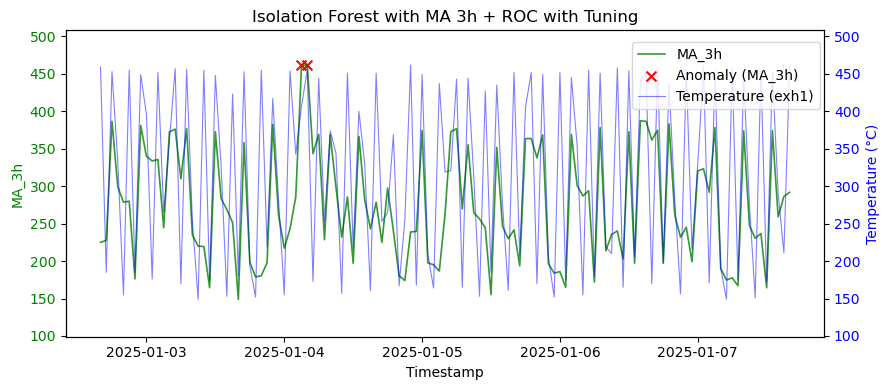

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data untuk visualisasi
timestamps = test_data_MA_3h['Timestamp']
temperature_values = test_data_MA_3h['temperature_exh1']
MA_3h_values = test_data_MA_3h['MA_3h']
anomalies = test_data_MA_3h['anomaly']  # Kolom 'anomaly' yang sudah ada

# Normalisasi MA_3h ke dalam rentang suhu
MA_3h_min, MA_3h_max = MA_3h_values.min(), MA_3h_values.max()
temp_min, temp_max = temperature_values.min(), temperature_values.max()

# Normalisasi MA_3h menggunakan Min-Max Scaling ke rentang suhu
scaled_MA_3h_values = (MA_3h_values - MA_3h_min) / (MA_3h_max - MA_3h_min) * (temp_max - temp_min) + temp_min

# Tentukan rentang yang sama untuk kedua grafik pada sumbu Y
y_min = min(temperature_values.min(), scaled_MA_3h_values.min()) - 50
y_max = max(temperature_values.max(), scaled_MA_3h_values.max()) * 1.1

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot MA_3h yang sudah diskalakan di sumbu kiri dengan garis tipis
ax1.plot(timestamps, scaled_MA_3h_values, label='MA_3h', color='green', linestyle='-', alpha=0.8, linewidth=1.2)
ax1.set_ylabel('MA_3h', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y

# Menandai titik anomali pada MA_3h (berdasarkan kolom anomaly)
ax1.scatter(timestamps[anomalies == 1], scaled_MA_3h_values[anomalies == 1], 
            color='red', label='Anomaly (MA_3h)', marker='x', s=50)

# Buat sumbu kanan untuk Temperature (exh1) dengan garis tipis
ax2 = ax1.twinx()
ax2.plot(timestamps, temperature_values, label='Temperature (exh1)', color='blue', alpha=0.5, linewidth=0.8)
ax2.set_ylabel('Temperature (°C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y agar sejajar

# Tambahkan judul dan legenda
ax1.set_xlabel('Timestamp')
ax1.set_title('Isolation Forest with MA 3h + ROC with Tuning')

# Letakkan legenda di tengah kiri
fig.legend(loc='upper left', bbox_to_anchor=(0.7, 0.9))

# Rotasi label timestamp agar lebih mudah dibaca
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Tampilkan grafik
plt.show()


In [36]:
dd

NameError: name 'dd' is not defined

## 4. MA + ROC + Suhu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

# Apakah ingin menggunakan hyperparameter tuning?
use_hypertuning = True  # Ganti ke False jika ingin menggunakan Isolation Forest default

# Copy dataset
data_MA_3h = data.copy()
features_column = ['MA_3h','ROC', 'temperature_exh1']  # Sesuaikan fitur yang digunakan
timestamp = data_MA_3h['Timestamp']


# Menghapus NaN karena rolling window menghasilkan nilai kosong di awal
data_MA_3h = data_MA_3h.dropna(subset=features_column).reset_index(drop=True)

# Membagi data menjadi train (80%) dan test (20%) secara berurutan
split_index = int(len(data_MA_3h) * 0.8)
train_data_MA_3h = data_MA_3h.iloc[:split_index].copy()
test_data_MA_3h = data_MA_3h.iloc[split_index:].copy()

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': ['auto',0.5, 0.8, 1.0],
        'contamination': [0.05, 0.1, 0.15]
    }

    model = IsolationForest(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(train_data_MA_3h[features_column])

    # Menggunakan model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    model = grid_search.best_estimator_

else:
    # Jika tidak menggunakan tuning, gunakan parameter default
    model = IsolationForest(contamination=0.1, n_estimators=50,random_state=42)
    model.fit(train_data_MA_3h[features_column])

# Memprediksi anomali pada data test
test_data_MA_3h['anomaly'] = model.predict(test_data_MA_3h[features_column])
test_data_MA_3h['anomaly'] = test_data_MA_3h['anomaly'].map({1: 0, -1: 1})  # Konversi (-1) ke 1 (anomali), (1) ke 0 (normal)

# Mendapatkan decision scores dari model
test_data_MA_3h['decision_score'] = model.decision_function(test_data_MA_3h[features_column])

# Menghitung statistik dari decision scores
decision_max = test_data_MA_3h['decision_score'].max()
decision_mean = test_data_MA_3h['decision_score'].mean()
decision_min = test_data_MA_3h['decision_score'].min()
decision_std = test_data_MA_3h['decision_score'].std()

# Menghitung Proportion of Anomalies (PAD)
proportion_anomalies = test_data_MA_3h['anomaly'].mean() * 100

# Menampilkan hasil evaluasi
print(f'Decision Scores (Max): {decision_max:.6f}')
print(f'Decision Scores (Mean): {decision_mean:.6f}')
print(f'Decision Scores (Min): {decision_min:.6f}')
print(f'Decision Scores (Std Dev): {decision_std:.6f}')
print(f'Proportion of Anomalies: {proportion_anomalies:.2f}%')


Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Best Hyperparameters: {'contamination': 0.05, 'max_samples': 'auto', 'n_estimators': 50}
Decision Scores (Max): 0.122505
Decision Scores (Mean): 0.075133
Decision Scores (Min): -0.027966
Decision Scores (Std Dev): 0.028555
Proportion of Anomalies: 2.48%


In [ ]:
test_data_MA_3h['anomaly'].value_counts()

anomaly
0    118
1      3
Name: count, dtype: int64

In [ ]:
test_data_MA_3h = test_data_MA_3h[['Timestamp', 'temperature_exh1', 'MA_3h','ROC','anomaly', 'decision_score']]
test_data_MA_3h_anomalies = test_data_MA_3h[test_data_MA_3h['anomaly']==1]
test_data_MA_3h_anomalies

Timestamp  temperature_exh1       MA_3h   ROC  anomaly  \
515 2025-01-04 03:00:00               407  401.333333  64.0        1   
516 2025-01-04 04:00:00               455  401.666667  48.0        1   
533 2025-01-04 21:00:00               256  264.000000  89.0        1   

     decision_score  
515       -0.026639  
516       -0.010144  
533       -0.027966

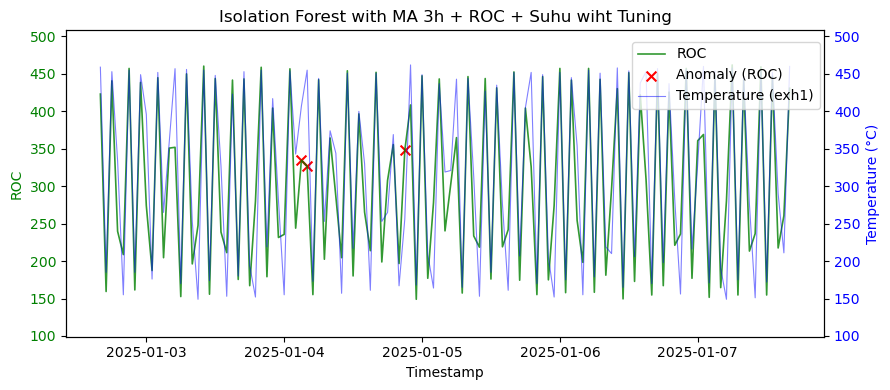

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data untuk visualisasi
timestamps = test_data_MA_3h['Timestamp']
temperature_values = test_data_MA_3h['temperature_exh1']
MA_3h_values = test_data_MA_3h['ROC']
anomalies = test_data_MA_3h['anomaly']  # Kolom 'anomaly' yang sudah ada

# Normalisasi MA_3h ke dalam rentang suhu
MA_3h_min, MA_3h_max = MA_3h_values.min(), MA_3h_values.max()
temp_min, temp_max = temperature_values.min(), temperature_values.max()

# Normalisasi MA_3h menggunakan Min-Max Scaling ke rentang suhu
scaled_MA_3h_values = (MA_3h_values - MA_3h_min) / (MA_3h_max - MA_3h_min) * (temp_max - temp_min) + temp_min

# Tentukan rentang yang sama untuk kedua grafik pada sumbu Y
y_min = min(temperature_values.min(), scaled_MA_3h_values.min()) - 50
y_max = max(temperature_values.max(), scaled_MA_3h_values.max()) * 1.1

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot MA_3h yang sudah diskalakan di sumbu kiri dengan garis tipis
ax1.plot(timestamps, scaled_MA_3h_values, label='ROC', color='green', linestyle='-', alpha=0.8, linewidth=1.2)
ax1.set_ylabel('ROC', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y

# Menandai titik anomali pada MA_3h (berdasarkan kolom anomaly)
ax1.scatter(timestamps[anomalies == 1], scaled_MA_3h_values[anomalies == 1], 
            color='red', label='Anomaly (ROC)', marker='x', s=50)

# Buat sumbu kanan untuk Temperature (exh1) dengan garis tipis
ax2 = ax1.twinx()
ax2.plot(timestamps, temperature_values, label='Temperature (exh1)', color='blue', alpha=0.5, linewidth=0.8)
ax2.set_ylabel('Temperature (°C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y agar sejajar

# Tambahkan judul dan legenda
ax1.set_xlabel('Timestamp')
ax1.set_title('Isolation Forest with MA 3h + ROC + Suhu wiht Tuning')

# Letakkan legenda di tengah kiri
fig.legend(loc='upper left', bbox_to_anchor=(0.7, 0.9))

# Rotasi label timestamp agar lebih mudah dibaca
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Tampilkan grafik
plt.show()
